In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import corner
import importlib
import logging
import os
from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

importlib.reload(logging)

# limit GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(gpus[1],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


In [2]:
data = np.load('../../Data/sample_NuFit0911.npz')
data_all = np.column_stack([data['ve_dune'][:,:36], data['vu_dune'][:,:36], data['vebar_dune'][:,:36], data['vubar_dune'][:,:36]])

In [3]:
training_data = np.load("../../Data/n1000000_0910_all_flat.npz")
data_all = np.column_stack([training_data['ve_dune'][:,:36], training_data['vu_dune'][:,:36], training_data['vebar_dune'][:,:36], training_data['vubar_dune'][:,:36]])

# theta13, theta23, delta
target = np.column_stack([training_data["theta13"]/180*np.pi, training_data["theta23"]/180*np.pi,
                         training_data["delta"]/180*np.pi])

split = 900000
x_train = data_all[:split]
y_train = target[:split]
x_train_poisson = np.random.poisson(x_train)/1000

x_val = data_all[split:]
y_val = target[split:]
x_val_poisson = np.random.poisson(x_val)/1000

In [4]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential([
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)))])
    return prior_model

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential([
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ), tfp.layers.MultivariateNormalTriL(n),])
    return posterior_model

In [5]:
hidden_units = [32, 16]
learning_rate = 0.001

In [54]:
def create_bnn_model(train_size):
    inputs = tf.keras.Input(shape=(len(x_train[0]),), name = 'input')
    features = tf.keras.layers.BatchNormalization()(inputs)
    features = tf.keras.layers.Dense(128, activation='relu')(features)
    features = tf.keras.layers.Dense(64, activation='relu')(features)
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="relu",
        )(features)
    features = tf.keras.layers.Dense(8, activation='relu')(features)
    outputs = tf.keras.layers.Dense(2)(features)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [61]:
bnn = create_bnn_model(split)
bnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()],
)
bnn.load_weights('./bnn/weight_10.h5')

In [62]:
result = []
for _ in tqdm(np.arange(100)):
    result.append(bnn.predict(data_all[:1, :])[0])
result = np.array(result)

100%|██████████| 100/100 [00:05<00:00, 16.99it/s]


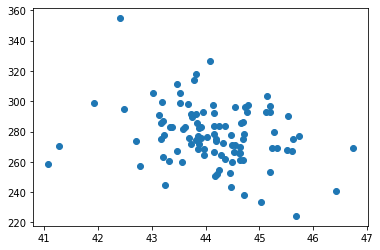

In [63]:
plt.scatter(result[:, 0]*180/np.pi, result[:, 1]*180/np.pi)

In [14]:
N_DUNE, N_T2HK, N_DUT2 = 92, 36, 96
theta23_DUNE, delta_cp_DUNE, chi_DUNE = [], [], []
theta23_T2HK, delta_cp_T2HK, chi_T2HK = [], [], []
theta23_DUT2, delta_cp_DUT2, chi_DUT2 = [], [], []

In [15]:
f_DUNE = open("../../Data/chi_square-4-2_figB_DUNE.txt")
for i in range(N_DUNE):
    s = f_DUNE.readline().split()
    array = []
    for j in range(len(s)) :
        array.append(float(s[j])) 
    theta23_DUNE.append(array[0])
    delta_cp_DUNE.append(array[1]) 
    chi_DUNE.append(array[2])
f_DUNE.close()

In [16]:
theta23_DUNE = np.array(theta23_DUNE)
delta_cp_DUNE = np.array(delta_cp_DUNE)
chi_DUNE = np.array(chi_DUNE)

In [17]:
x0 = np.linspace(min(theta23_DUNE)-3, max(theta23_DUNE)+3, 68)
y0 = np.linspace(min(delta_cp_DUNE)-6, max(delta_cp_DUNE)+6, 20)
X0, Y0 = np.meshgrid(x0, y0)
Z0 = np.zeros((len(X0),len(X0[0])))

for i in range(len(theta23_DUNE)):
    a = np.where(X0 == theta23_DUNE[i])[1][0]
    b = np.where(Y0 == delta_cp_DUNE[i])[0][0]
    Z0[b][a] = 1

/usr/local/lib/python3.8/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_3766767/1776730117.py:12: UserWarning: No contour levels were found within the data range.
  DUT2 = plot_axis.contour(X0, Y0, Z0, 0, colors='blue', linestyles="-", linewidths=1)


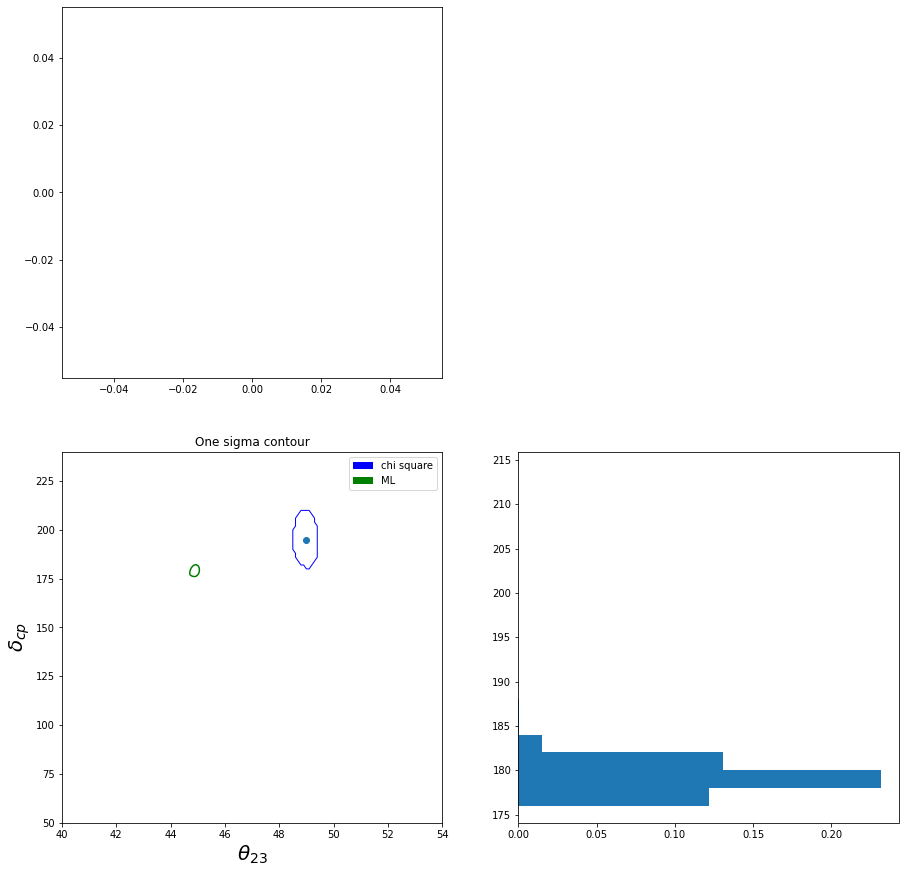

In [18]:
range = [[40,54], [50, 240]]
fig, ax = plt.subplots(1,1, figsize=(15,15))
plot_axis = plt.subplot(2,2,1)
plot_axis.hist(result[:, 1]*180/np.pi,density=1,bins=x0)

plot_axis = plt.subplot(2,2,4)

plot_axis.hist(result[:, 2]*180/np.pi,orientation="horizontal",density=1, bins=y0)

plot_axis = plt.subplot(2,2,3)
plot_axis.set_title('One sigma contour')
DUT2 = plot_axis.contour(X0, Y0, Z0, 0, colors='blue', linestyles="-", linewidths=1)
corner.hist2d(result[:, 1]*180/np.pi, result[:, 2]*180/np.pi,
                    levels=(0.68,),
                    scale_hist=True,
                    plot_datapoints=False,
                    color='green',
                    labels= ["$\\theta_{23} $($^\circ$)", "$\delta_{cp} $($^\circ$)"],
                    range=range,
                    plot_contours = True,
                    plot_density = False,
                    fontsize=30,
                    bins = [200, 200],
                    label_kwargs={"fontsize": 30},
                    smooth=True
                   )
plt.scatter(data['theta23'][0], data['delta'][0])
plot_axis.set_xlabel(r'$\theta_{23} $', fontsize=20)
plot_axis.set_ylabel(r'$\delta_{cp} $', fontsize=20)
proxy = [plt.Rectangle((2, 2), 0.0, 3, 90, fc=c) for c in ['blue', 'green']]
plt.legend(proxy, ["chi square", "ML"])
plt.show()